In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_teddynote import logging
logging.langsmith('test_node')

LangSmith 추적을 시작합니다.
[프로젝트명]
test_node


In [13]:
from RAG.database.milvus_connector import connect_to_milvus
connect_to_milvus()

Connected to Milvus-tailorlink


In [3]:
from langgraph.graph import StateGraph, START, END
from RAG.types import State

In [4]:
graph_builder = StateGraph(State)

In [5]:
from RAG.nodes.nodes import genesis_check, query_rewrite, vector_search, calculate_score,genesis_check_conditional,calculate_score_conditional


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
graph_builder.add_node("genesis_check", genesis_check)
graph_builder.add_node("vector_search", vector_search)
graph_builder.add_node("calculate_score", calculate_score)
graph_builder.add_node("query_rewrite", query_rewrite)

In [7]:
# START > chatbot
graph_builder.add_edge(START, "genesis_check")
graph_builder.add_edge('query_rewrite', "vector_search")
graph_builder.add_edge('vector_search', "calculate_score")
graph_builder.add_edge('query_rewrite', "vector_search")

In [8]:
graph_builder.add_conditional_edges(
    'genesis_check',
    genesis_check_conditional,
    path_map={"search": "vector_search", END: END},
)

graph_builder.add_conditional_edges(
    "calculate_score",
    calculate_score_conditional,
    path_map={"rewrite": "query_rewrite", END: END},
)

In [9]:
# 그래프 컴파일
graph = graph_builder.compile()

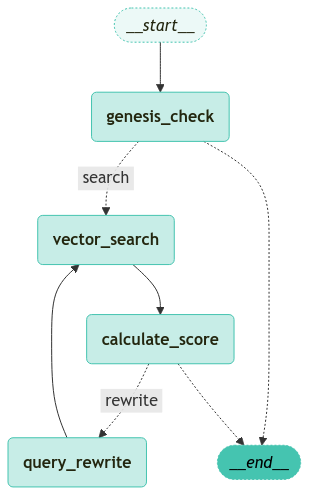

In [10]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [14]:
state: State = {
    "message":'파워트렁크는 뭐야??',
    "context": [],
    "answer": "",
    "change_count": 0,
    "is_valid_question": False,
    "is_pass": False,
    "previous_question": [],
    "best_answer": "",
    "best_score": 0,
}


res= graph.invoke(state)

판단 시작
벡터 조회
Embeddings: {'dense': [array([ 0.00348099, -0.0265577 , -0.01553365, ..., -0.01481336,
       -0.02737851, -0.02662311], dtype=float32)], 'sparse': <Compressed Sparse Row sparse array of dtype 'float64'
	with 9 stored elements and shape (1, 250002)>}
Dense query dim: 1024 (1024,)
Sparse query dim: 250002 (250002,)
점수 측정
점수: 100 


In [15]:
print(res['best_answer'])

### 질문에 대한 답변:  
G90의 파워 트렁크는 차량의 트렁크를 자동으로 열고 닫을 수 있는 시스템입니다. 이 시스템은 사용자가 트렁크를 위로 올리거나 아래로 내릴 때, 일정한 힘을 감지하여 자동으로 작동합니다. 

- **작동 방식**: 
  - 트렁크를 위로 올리면 파워 트렁크 시스템이 이를 감지하여 트렁크를 완전히 엽니다.
  - 트렁크를 아래로 내리면 시스템이 트렁크를 완전히 닫습니다.
  - 만약 물체의 끼임이 감지되면 작동이 멈추고, 사용자는 수동으로 트렁크를 열거나 닫아야 합니다.

- **안전 기능**: 
  - 트렁크가 일정 높이 이상 열려 있지 않으면 기능이 작동하지 않을 수 있으며, 경사가 있는 곳에서는 트렁크가 완전히 열리기 전에 정지할 수 있습니다.
  - 트렁크가 닫히는 도중에 버튼에서 손을 떼면 작동이 멈추고 경고음이 울립니다.

- **스마트 키 사용**: 
  - 차량이 잠긴 상태에서 스마트 키를 소지하고 버튼을 누르면 트렁크가 열리며, 버튼을 길게 누르면 트렁크가 닫힙니다. 

이러한 기능들은 사용자의 편의성을 높이고, 부상이나 사고를 예방하는 데 도움을 줍니다.

### 출처:  
1. CONTEXT 기반 정보: 파워 트렁크 시스템의 작동 방식 및 안전 기능에 대한 설명.


In [13]:
from RAG.database.milvus_connector import connect_to_milvus
connect_to_milvus()

Connected to Milvus-tailorlink


In [1]:
from langchain.tools import tool
from RAG.tools.milvus_search import dense_search, hybrid_search, sparse_search
from RAG.llm.embedding import generate_query_embedding
from RAG.database.milvus_connector import get_collection


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
from langchain.tools import Tool

# Search Milvus Tool Definition
def search_milvus_tool(query: str) -> list:
    query_embeddings = generate_query_embedding([query])
    hybrid_results = hybrid_search(
        get_collection('manual'),
        query_embeddings["dense"][0],
        query_embeddings["sparse"]._getrow(0),
        sparse_weight=0.7,
        dense_weight=1.0,
    )
    return hybrid_results

# Create the Runnable Tool
search_milvus = Tool(
    name="search_milvus",
    func=search_milvus_tool,
    description=(
        "A tool to search in the Milvus vector database using hybrid search. "
        "It combines dense and sparse embeddings for improved search results."
    )
)

In [14]:
search_milvus.invoke('안전벨트')

Embeddings: {'dense': [array([-0.01287675,  0.03408073, -0.04706139, ...,  0.00987844,
       -0.03477947,  0.03609258], dtype=float32)], 'sparse': <Compressed Sparse Row sparse array of dtype 'float64'
	with 3 stored elements and shape (1, 250002)>}
Dense query dim: 1024 (1024,)
Sparse query dim: 250002 (250002,)
Connected to Milvus


['안전벨트로 인해 복부 등에 강 한 힘을 받을 수 있습니다. 안전벨트 착용 여부를 의사와 상의하십시오. • 안전벨트를 착용할 때 다른 사람의 버클에 플레이트를 체결하지 마십시오. 안전벨트 의 보호를 제대로 받지 못할뿐더러 사고 위험이 커질 수 있습니다. 3-36 RS4_G90_KO.book Page 37 3 • 주행 중 좌석 등받이는 항상 똑바로 세워 (cid:1155)(cid:1162) 져 있어야 합니다. 안전벨트 장치는 등받 다음의 경고 사항들을 준수하지 않으면, 사 이가 똑바로 세워져 있을 때, 최대의 보호 고가 났을 때 더 큰 부상을 당할 위험이 있습 기능을 발휘합니다. 니다. 안전벨트를 착용한 채 좌석 등받이를 뒤로 • 벨트의 어깨띠를 팔 밑이나 등 뒤로 착용 젖히지 마십시오. 신체가 안전벨트에 바르',
 "ALR 안전벨트는 어린이용 보조 좌석을 장 착했을 때 안전성을 높이는 장치입니다. 뒷좌석 안전벨트에 장착되어 있습니다. 평 소에는 ELR 모드로 사용하고, 어린이용 보 조 좌석을 장착하면 ALR 모드로 변경하십 시오. 자세한 내용은 3장 내 '어린이 보호용 장치 (보조 좌석)'를 참고하십시오. ORS031130 안전벨트를 사용하면, 사고나 급정차 시에 (cid:1155)(cid:1162) 당할 수 있는 심각한 부상이나 사망의 위험 • 도어를 닫을 때 안전벨트가 도어 틈 사이 이 줄어듭니다. 안전벨트는 다음과 같은 상 에 끼지 않도록 주의하십시오. 안전벨트의 태에서 최대의 효과를 발휘합니다. 성능이 떨어져 사고 시 위험합니다. • 탑승자가 엉덩이를 좌석에 깊게 걸치고 등 • 주행 전에 운전자는 모든 좌석 등받이가 을 등받이에 똑바로 기대고 앉은",
 '3 안전벨트 사용 시 유의 사항 안전벨트의 적절한 관리 큰 어린이의 안전벨트 착용 (cid:2737)(cid:2628) 어린이의 체격에 맞는 알맞은 좌석 환경을 • 안전벨트에 손상을 줄 수 있는 물체(끝이 만드십시오. 뾰족한 물체 등)가 닿지 않도록 하십시오. 큰 어린이가 차량에 장착된 안전벨트를 착

In [12]:
from langchain.tools import Tool
# Search Milvus Tool Definition
@tool
def search_milvus_tool(query: str) -> list:
    """
    Search in the Milvus vector database using hybrid search.
    Combines dense and sparse embeddings for improved results.
    
    Args:
        query (str): The input query string.
        
    Returns:
        list: A list of search results from Milvus.
    """
    query_embeddings = generate_query_embedding([query])
    hybrid_results = hybrid_search(
        get_collection('manual'),
        query_embeddings["dense"][0],
        query_embeddings["sparse"]._getrow(0),
        sparse_weight=0.7,
        dense_weight=1.0,
        limit=20
    )
    return hybrid_results

In [18]:
from RAG.tools.tools import search_milvus

search_milvus.invoke('안전벨트에 대해서 알려줘')

Embeddings: {'dense': [array([-0.02611502,  0.02356263, -0.07463723, ..., -0.00469884,
       -0.01070711,  0.0074196 ], dtype=float32)], 'sparse': <Compressed Sparse Row sparse array of dtype 'float64'
	with 7 stored elements and shape (1, 250002)>}
Dense query dim: 1024 (1024,)
Sparse query dim: 250002 (250002,)


['안전벨트로 인해 복부 등에 강 한 힘을 받을 수 있습니다. 안전벨트 착용 여부를 의사와 상의하십시오. • 안전벨트를 착용할 때 다른 사람의 버클에 플레이트를 체결하지 마십시오. 안전벨트 의 보호를 제대로 받지 못할뿐더러 사고 위험이 커질 수 있습니다. 3-36 RS4_G90_KO.book Page 37 3 • 주행 중 좌석 등받이는 항상 똑바로 세워 (cid:1155)(cid:1162) 져 있어야 합니다. 안전벨트 장치는 등받 다음의 경고 사항들을 준수하지 않으면, 사 이가 똑바로 세워져 있을 때, 최대의 보호 고가 났을 때 더 큰 부상을 당할 위험이 있습 기능을 발휘합니다. 니다. 안전벨트를 착용한 채 좌석 등받이를 뒤로 • 벨트의 어깨띠를 팔 밑이나 등 뒤로 착용 젖히지 마십시오. 신체가 안전벨트에 바르',
 '3 안전벨트 사용 시 유의 사항 안전벨트의 적절한 관리 큰 어린이의 안전벨트 착용 (cid:2737)(cid:2628) 어린이의 체격에 맞는 알맞은 좌석 환경을 • 안전벨트에 손상을 줄 수 있는 물체(끝이 만드십시오. 뾰족한 물체 등)가 닿지 않도록 하십시오. 큰 어린이가 차량에 장착된 안전벨트를 착용 • 안전벨트를 청소할 때는 내장재나 카펫 청 할 경우, 착용 후 어깨띠의 위치를 확인하십 소에 사용되는 부드러운 비누액을 사용하 시오. 어깨띠가 어린이의 목이나 얼굴에 닿 십시오. 으면 어린이를 뒷좌석 중앙에 앉히십시오. 뒷좌석 중앙의 안전벨트도 어깨띠가 어린이 의 목이나 얼굴에 닿으면 어린이용 보조 좌 석에 앉히십시오. (cid:1155)(cid:1162) • 안전벨트를 표백하거나 염색하지 마십시 (cid:1155)(cid:1162) 오. 표백이나 염색 시 안전벨트가 약해져 서 충돌',
 '니다. 안전벨트를 착용한 채 좌석 등받이를 뒤로 • 벨트의 어깨띠를 팔 밑이나 등 뒤로 착용 젖히지 마십시오. 신체가 안전벨트에 바르 하지 마십시오. 게 고정되지 않아 충돌 또는 급정차할 때 목이 걸리거나 부상을 입을 수 있습니다. • 안전벨트의 어깨띠가 목이

In [13]:
query = '시동 거는 법?'
docs = search_milvus_tool.invoke(query)

Embeddings: {'dense': [array([-0.00245594,  0.02500322, -0.01089139, ..., -0.03254781,
        0.01484121, -0.00483145], dtype=float32)], 'sparse': <Compressed Sparse Row sparse array of dtype 'float64'
	with 6 stored elements and shape (1, 250002)>}
Dense query dim: 1024 (1024,)
Sparse query dim: 250002 (250002,)
Connected to Milvus


In [10]:
from pymilvus.model.reranker import BGERerankFunction

# Define the rerank function
bge_rf = BGERerankFunction(
    model_name="BAAI/bge-reranker-v2-m3",  # Specify the model name. Defaults to `BAAI/bge-reranker-v2-m3`.
    device="cpu" # Specify the device to use, e.g., 'cpu' or 'cuda:0'
)

In [14]:


results = bge_rf(
    query=query,
    documents=docs,
    top_k=5,
)

for result in results:
    print(f"Index: {result.index}")
    print(f"Score: {result.score:.6f}")
    print(f"Text: {result.text}\n")


Index: 0
Score: 0.976392
Text: 이러한 특 성에 대한 이해가 없는 사람과 함께 스마트 키를 차 안에 둘 경우, 뜻밖의 상황이 발생할 수도 있으므로 항상 주의하십시오. 시동 및 출발 방법 1. 브레이크 페달을 밟은 상태에서 시동 버튼 을 누르십시오. 2.브레이크 페달을 계속 밟고 있는 상태에서 엔진 회전이 적정 범위(1,000 RPM 이내)에 있는지 확인한 후에 변속 다이얼을 원하는 위치로 돌리십시오. 3.전자식 파킹 브레이크를 해제한 후 브레이 크 페달에서 발을 떼면서 차량이 서서히 움직이는 것을 확인하고 가속 페달을 천천 히 밟아 출발하십시오. 6-5 RS4_G90_KO.book Page 6 시동 및 주행 (cid:2444)(cid:2439)(cid:1601)(cid:1245) 제동 스위치 퓨즈가 고장 났을 때 시동 거는 방법 • 변속 장금 장치(Shift Lock)가 장착된 차량 제동

Index: 1
Score: 0.883269
Text: 걸려면 스마트폰 제조사 용하여 한 번 도어 잠금/잠금 해제를 사용 에서 제공하는 앱을 사용하여 도어 잠금 하거나 실내 인증 패드(무선 충전 패드)에 버튼으로 차량을 잠그고, 4초 이내에 원격 서 시동을 걸면 디지털 키(스마트폰)가 차 시동 버튼을 누르십시오. 량에 등록됩니다. 시동이 걸리고 비상 경고등이 깜빡입니다. 시동을 끄려면 원격 시동 버튼을 다시 누 르십시오. (cid:1155)(cid:1162) 기본적인 차량 버튼 시동 방법은 6장 내 '시 디지털 키로 등록된 스마트폰이 실내에 있을 동 버튼'을 참고하십시오. 경우 시동을 걸 수 있습니다. 따라서, 이러한 차량 시스템을 모르는 사람이나 어린이들을 혼자 차 안에 남겨 두면 예기치 못한 사고가 일어날 수 있으므로 주의하십시오. 또한, 차 량 도난의 우려가 있으므로

Index: 4
Score: 0.860078
Text: 및 주행 (cid:2444)(cid:2439)(cid:1601)(cid:1245) 제동 스위치 퓨즈가 고장 났을 때 시동 거

In [15]:
from pymilvus.model.reranker import CrossEncoderRerankFunction

ce_rf = CrossEncoderRerankFunction(
    model_name="cross-encoder/ms-marco-MiniLM-L-6-v2",  # Specify the model name.
    device="cpu" # Specify the device to use, e.g., 'cpu' or 'cuda:0'
)


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ChoiYounKyu\.cache\huggingface\hub\models--cross-encoder--ms-marco-MiniLM-L-6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

E:\TailorLink\SKN03-FINAL-6Team\TailorLink_LLM\doc_retrieval_qa\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
results = ce_rf(
    query=query,
    documents=docs,
    top_k=10,
)

for result in results:
    print(f"Index: {result.index}")
    print(f"Score: {result.score:.6f}")
    print(f"Text: {result.text}\n")

Index: 9
Score: 8.766023
Text: 시동을 완전히 끈 후 시동을 다시 거십시오. (cid:1155)(cid:1162) 위와 같은 방법으로도 시동이 걸리지 않으면 당사 직영 하이테크센터나 블루핸즈에서 점 급경사로에는 차를 주차하지 마십시오. 차가 검을 받으십시오. 움직일 수 있습니다. 6-7 RS4_G90_KO.book Page 8 시동 및 주행 스마트 키 원격 시동 ORS061002 차량과 10 m 이내 거리에서 스마트 키의 도 어 잠금(Č) 버튼을 누른 후 4초 이내에 원격 시동(ƙ) 버튼을 길게 누르십시오. • 시동이 걸리면 비상 경고등이 깜빡입니다. • 원격 시동을 끄려면 원격 시동(ƙ) 버튼을 다시 누르십시오. (cid:2444)(cid:2439)(cid:1601)(cid:1245) • 기어가 'P'(주차) 상태일 때에만 원격으로 시동을 걸 수 있습니다. • 원격 시동 상태에서 스마트 키를 휴대하지 않고 차량에 탑승하면 자동으로 시동이 꺼

Index: 16
Score: 8.735374
Text: 표시등(j)이 30초 동 지문을 인증하십시오 안 켜집니다. 이때 브레이크 페달을 밟고 시 동 버튼을 누르면 시동이 걸립니다. 인포테인먼트 시스템의 사용자 프로필 설정 단, 키 확인 표시등(j)이 켜진 후 30초 안에 에서 운전자 1 또는 운전자 2의 지문인식 시 시동 버튼을 눌러야 걸 수 있습니다. 키 확인 동이 설정되어 있고, 원격으로 시동을 건 상 표시등(j)이 꺼진 이후에는 지문 인증을 다 태에서 디지털 키 또는 제네시스 커넥티드 시 해야 합니다. 서비스로 도어를 잠금 해제한 후 도어를 열 면 이 경고문이 최대 30초 동안 표시됩니다. 이 경고문이 표시되는 동안에는 시동이 켜져 지문 인증이 제한되었습니다. ____ 분 후 있어도 차량 주행을 할 수 없으며,

Index: 8
Score: 8.654610
Text: 걸리지 않습니 체하십시오. 다. 즉시 퓨즈 교체가 어려운 경우에는 시동 버튼을 한 번 눌러 'ACC' 상태가 되게 한 후, 

In [3]:



from common.milvus_connector import connect_to_milvus
connect_to_milvus()

Connected to Milvus-tailorlink


In [ ]:
from doc_retrieval_qa.RAG.rag_pipeline import run_rag
res = run_rag('시동거는법?')

판단 시작
벡터 조회
Embeddings: {'dense': [array([-0.0165373 ,  0.03231683, -0.01011707, ..., -0.03665058,
        0.02336237,  0.0224731 ], dtype=float32)], 'sparse': <Compressed Sparse Row sparse array of dtype 'float64'
	with 6 stored elements and shape (1, 250002)>}
Dense query dim: 1024 (1024,)
Sparse query dim: 250002 (250002,)


In [ ]:
res